<a href="https://colab.research.google.com/github/beechainfullstack/COGS108_Repo/blob/main/109_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
%matplotlib inline

In [ ]:
df = pd.read_excel('/content/Real estate valuation data set.xlsx')

# Background

In our analysis, we aim to answer the following research question: ***Can determinants of real estate, or combinations of these determinants, be used to build an accurate real estate valuation model in Taipei, Taiwan?***

## Exploratory Data Analysis

In [ ]:
df.shape

(414, 8)

In [ ]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


We see that our dataset contains 414 samples of various real estate transactions with 7 different features of these transactions and one index column. These variables consist of 6 input variables:
*   the date of the transaction
*   the age of the house in years
*   the distance to the nearest transit station in meters
*   the number of convenience stores accessible by foot
*   the latitude coordinate
*   the longitude coordinate
 
and one output variable
*   price per unit area of the unit

In [ ]:
# Data transformation
df.rename(columns = {'X1 transaction date': 'Transaction Date',
                    'X2 house age': 'House Age',
                    'X3 distance to the nearest MRT station': 'Metro Station Distance',
                    'X4 number of convenience stores': 'Nearby Convenience Stores',
                    'X5 latitude': 'Latitude',
                    'X6 longitude': 'Longitude',
                    'Y house price of unit area': 'Unit Area Price'
                    }, inplace = True)
 
# We can drop the unnecessary columns which cannot affect predictions
df = df.drop(['No'], axis = 1)

In [ ]:
# Checking for any missing values
df.isnull().sum()

Transaction Date             0
House Age                    0
Metro Station Distance       0
Nearby Convenience Stores    0
Latitude                     0
Longitude                    0
Unit Area Price              0
dtype: int64

In [ ]:
# Checking the statistical details of the dataset
df.describe()

,Transaction Date,House Age,Metro Station Distance,Nearby Convenience Stores,Latitude,Longitude,Unit Area Price
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


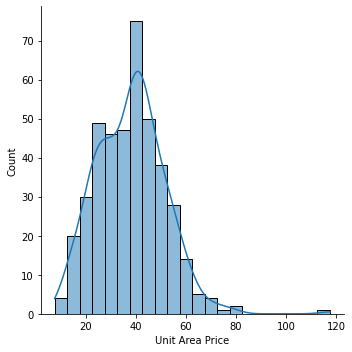

In [ ]:
# Checking the distribution of the unit area prices
sns.displot(df['Unit Area Price'], kde=True)
plt.show()

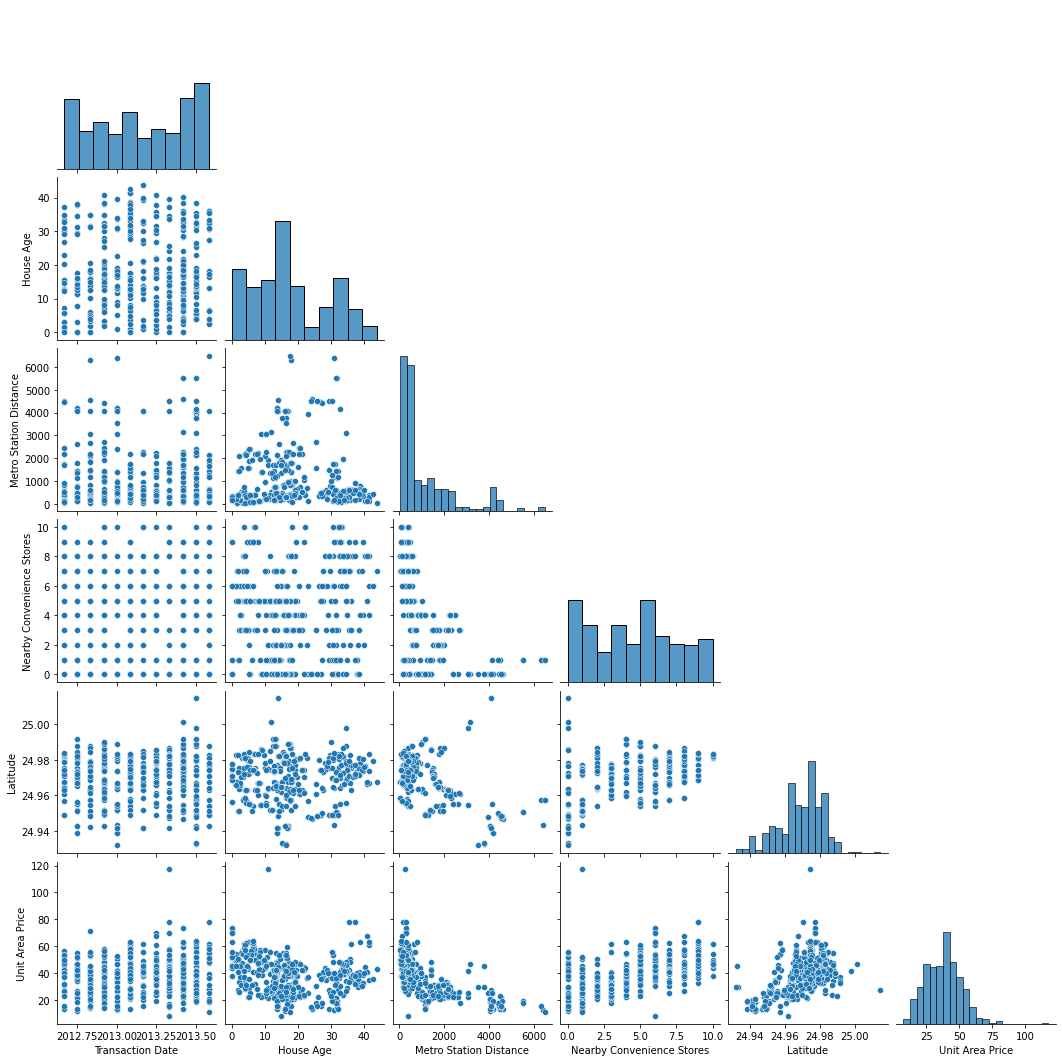

In [ ]:
# Checking the relationship of each variable to one another
sns.pairplot(df, corner = True)
plt.show()

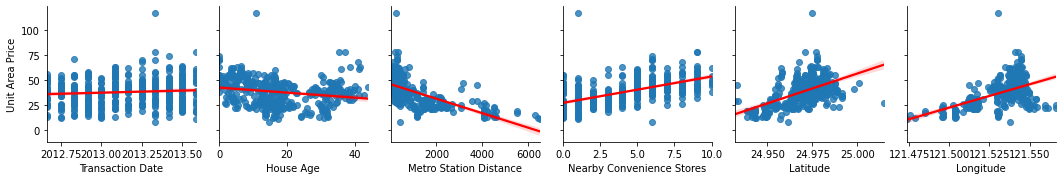

In [ ]:
# Taking a closer look at the relationship of the unit area price to all the independent variables
sns.pairplot(df, y_vars = 'Unit Area Price', x_vars = df.drop(['Unit Area Price'], axis = 1), kind="reg", plot_kws={'line_kws':{'color':'red'}})
plt.show()

At quick glance it seems that there is little correlation between the transaction dates to the unit area price. We should take this into consideration moving forward as a variable to exclude from our model.

# Methods

We will be using a heatmap to look for any correlation between our independent variables, followed by looking at the Variance Inflation Factor of each variable to look for any collinearity not apparent in the heatmap. 

After addressing any collinearity we will be using functions from the scikit-learn library to create our linear regression model. To cross validate our model we will be using a train/test split of 2/3 training to 1/3 testing and subsequently calculate the SSE values for the train and test data of both our models to check if we have avoided overfitting the model to the training data. 

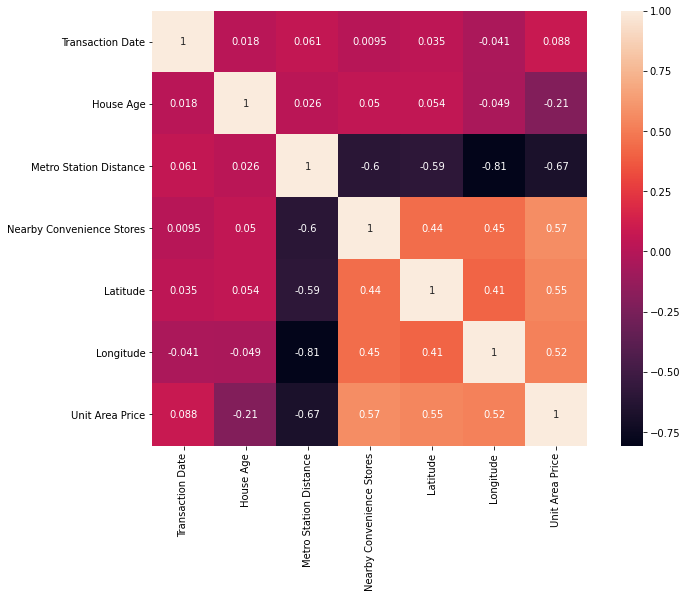

In [ ]:
# Heatmap to observe correlation between the variables, checking for collinearity
plt.figure(figsize = (12, 8))
sns.heatmap(df.corr(), annot = True, square = True)
plt.show()

In [ ]:
# Longitude and Metro Station Distance appear to have high collinearity, thus we should remove one of the variables to address this
df = df.drop(['Longitude'], axis = 1)

In [ ]:
# Checking for the variance inflation factor may help us find any more hidden collinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_1 = df.drop(['Unit Area Price'], axis = 1)
 
def vif_calc(X_1):
  vif = pd.DataFrame()
  vif['Variables'] = X_1.columns
  vif['VIF'] = [variance_inflation_factor(X_1.values, i) for i in range(X_1.shape[1])]
  return(vif)

vif_calc(X_1).round(3)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,Variables,VIF
0,Transaction Date,5989705.143
1,House Age,3.465
2,Metro Station Distance,3.499
3,Nearby Convenience Stores,4.696
4,Latitude,5988386.689


In [ ]:
# Latitude and Transaction Date a variance inflation factor greater than 5, thus we should remove one of the variables 
# to reduce any collinearity and rerun to see verify that we have reduced our VIF to less than 5
X_1 = X_1.drop(['Latitude'], axis = 1)

vif_calc(X_1).round(3)

,Variables,VIF
0,Transaction Date,9.273
1,House Age,3.448
2,Metro Station Distance,2.744
3,Nearby Convenience Stores,4.641


In [ ]:
# Transaction Date appears to still have a variance inflation factor greater than 5 affecting our  which should be addressed
X_1 = X_1.drop(['Transaction Date'], axis = 1)

vif_calc(X_1).round(3)

,Variables,VIF
0,House Age,2.776
1,Metro Station Distance,1.525
2,Nearby Convenience Stores,2.050


The variance inflation factor seems to at appropriate levels, indicating that there is no collinearity between the remaining variables that could affect negatively affect our model. This will give us a valuation model with higher accuracy predictions.

In [ ]:
X_1.head()

,House Age,Metro Station Distance,Nearby Convenience Stores
0,32.0,84.87882,10
1,19.5,306.59470,9
2,13.3,561.98450,5
3,13.3,561.98450,5
4,5.0,390.56840,5


# Results

In [ ]:
# Creating our regression model
X_1_train, X_1_test, y_train, y_test = train_test_split(X_1, y, test_size = 0.33, random_state = 12) # Splitting our data for cross validation
model_1 = LinearRegression().fit(X_1_train, y_train) # Fitting our model using the training data
test_predictor_1 = model_1.predict(X_1_test) 
train_predictor_1 = model_1.predict(X_1_train)

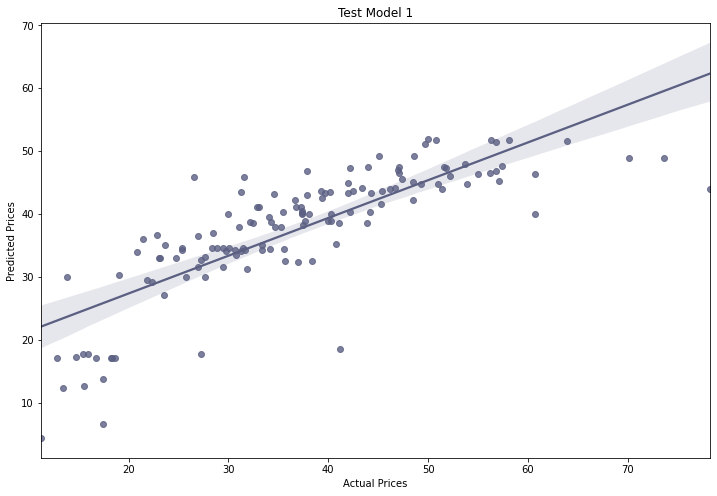

In [ ]:
plt.figure(figsize = (12, 8))
sns.regplot(x = y_test, y = test_predictor_1, data = df, color = '#5b5f82')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Test Model 1')
plt.show()

In [ ]:
# checking our model accuracy 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print('Model 1 Coefficient of Determination: ', r2_score(y_test, test_predictor_1))
print('Model 1 MSE: ', mean_squared_error(y_test, test_predictor_1))

Model 1 Coefficient of Determination:  0.6363328493890326
Model 1 MSE:  63.42820361896384


In [ ]:
# We can test for another model removing the variable that accounts for the least variance of the unit area price. 
# Of the three variables we have obtained, this would be house age. 
X_2 = X_1.drop(['House Age'], axis=1)

X_2.head()

,Metro Station Distance,Nearby Convenience Stores
0,84.87882,10
1,306.59470,9
2,561.98450,5
3,561.98450,5
4,390.56840,5


In [ ]:
# creating our second regression model 
X_2_train, X_2_test, y_train, y_test = train_test_split(X_2, y, test_size = 0.33, random_state = 12)
model_2 = LinearRegression().fit(X_2_train, y_train)
test_predictor_2 = model_2.predict(X_2_test)
train_predictor_2 = model_2.predict(X_2_train)

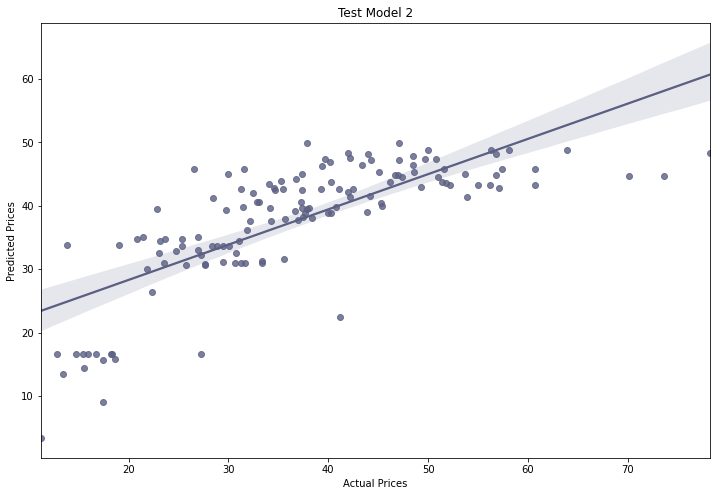

In [ ]:
# plotting our regression model
plt.figure(figsize = (12, 8))
sns.regplot(x = y_test, y = test_predictor_2, data = df, color = '#5b5f82')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Test Model 2')
plt.show()

In [ ]:
# model accuracy 
print('Model 2 Coefficient of Determination: ', r2_score(y_test, test_predictor_2))
print('Model 2 MSE: ', mean_squared_error(y_test, test_predictor_2))

Model 2 Coefficient of Determination:  0.5721165508525385
Model 2 MSE:  74.62834763083292


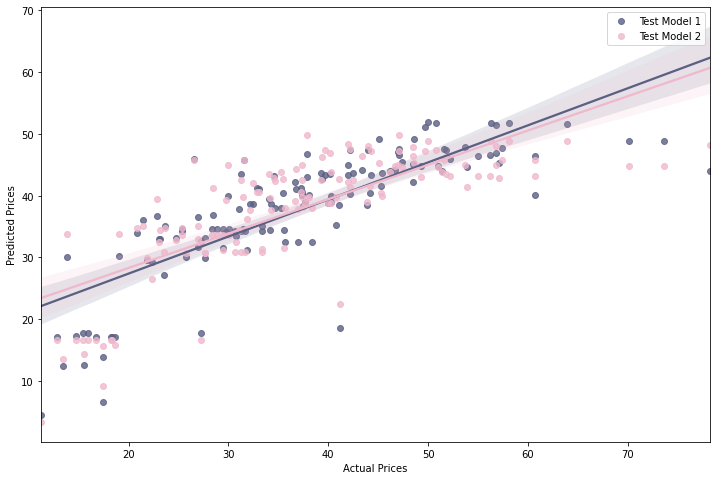

In [ ]:
# plotting our regression model
plt.figure(figsize = (12, 8))
sns.regplot(x = y_test, y = test_predictor_1, data = df, color = '#5b5f82', label = 'Test Model 1')
sns.regplot(x = y_test, y = test_predictor_2, data = df, color = '#efb8cc', label = 'Test Model 2')
plt.legend()
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

In [ ]:
test_rmse_1 = np.sqrt(mean_squared_error(y_test, test_predictor_1))
train_rmse_1 = np.sqrt(mean_squared_error(y_train, train_predictor_1))

test_rmse_2 = np.sqrt(mean_squared_error(y_test, test_predictor_2))
train_rmse_2 = np.sqrt(mean_squared_error(y_train, train_predictor_2))

test_sse_1 = np.sum((y_test - test_predictor_1)**2)
train_sse_1 = np.sum((y_train - train_predictor_1)**2)

test_sse_2 = np.sum((y_test - test_predictor_2)**2)
train_sse_2 = np.sum((y_train - train_predictor_2)**2)

print('Model 1 Test SSE:', test_sse_1)
print('Model 1 Train SSE:', train_sse_1)

print('Model 2 Test SSE:', test_sse_2)
print('Model 2 Train SSE:', train_sse_2)

Model 1 Test SSE: 8689.663895798047
Model 1 Train SSE: 26544.06776268154
Model 2 Test SSE: 10224.08362542411
Model 2 Train SSE: 28413.445462337444


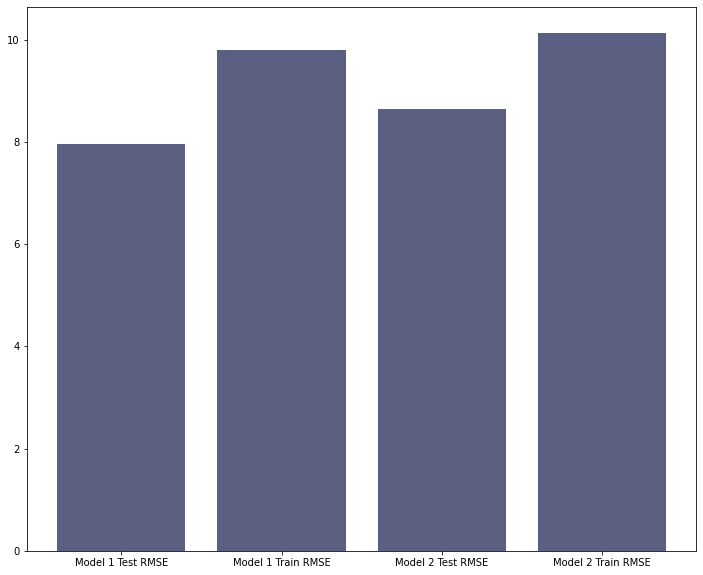

In [ ]:
fig = plt.figure (figsize = (12, 10))
set_split = {'Model 1 Test RMSE': test_rmse_1, 'Model 1 Train RMSE': train_rmse_1, 'Model 2 Test RMSE': test_rmse_2, 'Model 2 Train RMSE': train_rmse_2}

plt.bar(list(set_split.keys()), list(set_split.values()), color='#5b5f82')
plt.show()

# Discussion


Overall, both of our model's results suggest a positive correlation between actual and predicted real estate prices. Our first model, as it displays a lower training and test RMSE, acts as a more accurate representation of the correlation between actual and predictred valuations of real estate. Comparing the SSE values of the test and train data in both our models we can see that we have managed to avoid any overfitting as the SSE test is smaller than the SSE train. 

These factors answer our question, indicating that the best determinants for real estate property prices in Taipei, Taiwan seem to be the unit's age, the distance to the nearest transit station, and the number of convenience stores nearby. 

As our dataset represents real estate in the Sindian District of New Tapei City in Taiwan, it will have limitations with respect to predicting values in other areas of Taiwan. Another possible limitation lies in the possibility that other variables not accounted for in our dataset, such as property condition or interest rates, may serve as better predictors for real estate valuation. 

# References

https://etav.github.io/python/vif_factor_python.html 

https://blog.clairvoyantsoft.com/correlation-and-collinearity-how-they-can-make-or-break-a-model-9135fbe6936a

https://scikit-learn.org/stable/index.html 